## Application to scanpy PBMC3K

Preprocess is based on [the tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.8.1 anndata==0.7.6 umap==0.5.1 numpy==1.20.3 scipy==1.7.1 pandas==1.3.3 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.6 pynndescent==0.5.4


2022-06-13 22:03:57.572835: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:
2022-06-13 22:03:57.572865: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from sklearn.decomposition import NMF

from NMFprojection import *

In [3]:
adata = sc.datasets.pbmc3k()

In [4]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

filtered out 19024 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes


/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:04)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


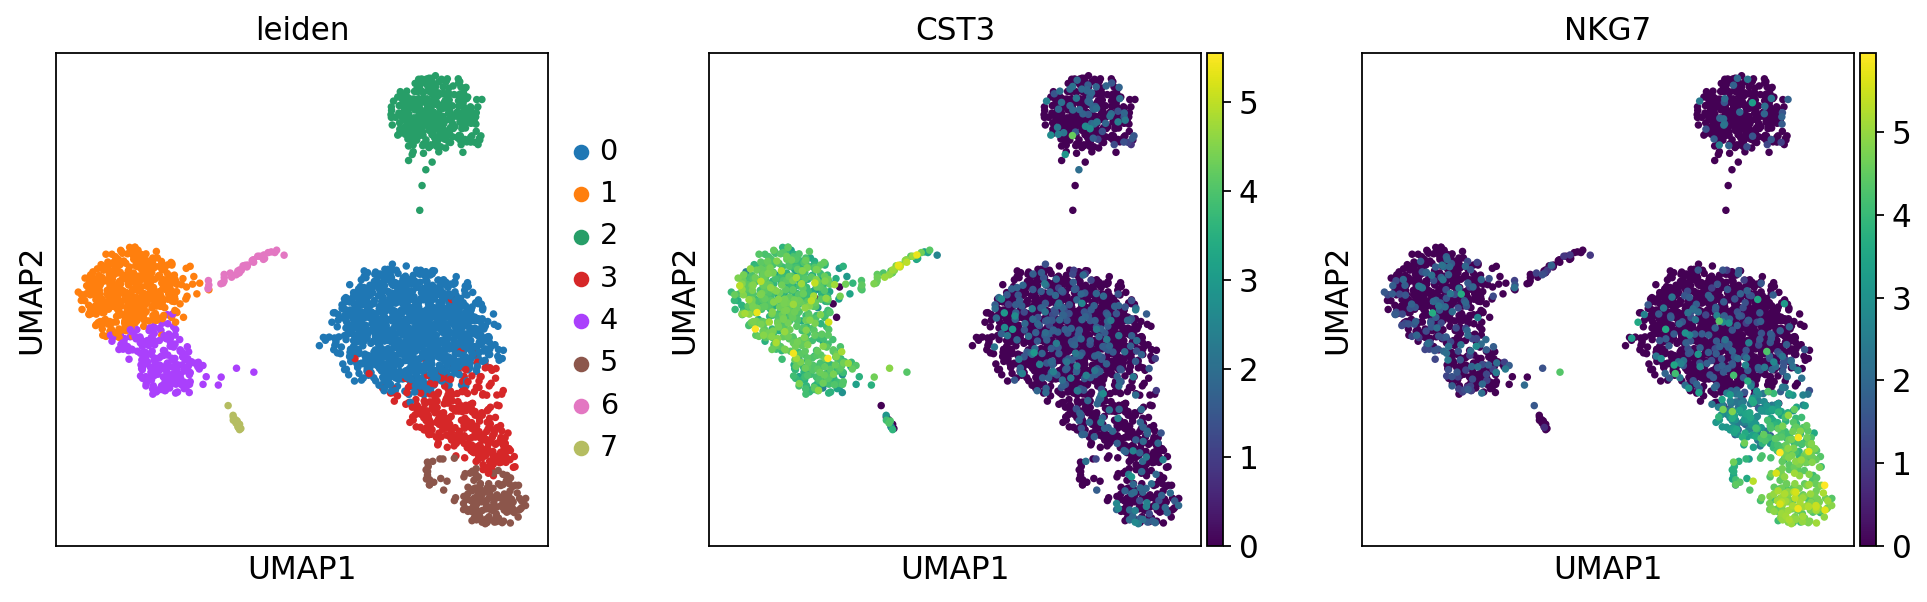

In [5]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata.raw = adata
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.tl.leiden(adata)

sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'], save=False)

In [6]:
arr_exp = adata.X
arr_exp = np.where(arr_exp > 0, arr_exp, 0)

In [7]:
arr_exp.shape

(2638, 1838)

## Determine appropriate number of components

In [8]:
%%time

list_evar = []
for n_comp in range(1,19):
    model = NMF(n_components=n_comp, init='random', random_state=seed)
    H = model.fit_transform(arr_exp)
    W = model.components_

    df_evar = calc_EV(arr_exp.T, pd.DataFrame(W).T, pd.DataFrame(H).T)
    evar = df_evar.loc['ALL', 'ExplainedVariance']
    corr = (np.array(pd.DataFrame(W).T.corr()) - np.eye(n_comp)).max()
    
    list_evar.append([n_comp, evar, corr])

/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 rea

CPU times: user 5min 36s, sys: 3min 41s, total: 9min 18s
Wall time: 39.1 s


In [9]:
df_evar = pd.DataFrame(list_evar, columns=['n_comp', 'Evar', 'corr'])
# df_evar.to_csv(str(sc.settings.figdir) + '/stats_components_NMF.csv')
df_evar

,n_comp,Evar,corr
0,1,0.076124,0.000000
1,2,0.089773,0.000000
2,3,0.099879,0.032757
3,4,0.107744,0.195163
4,5,0.114794,0.230418
5,6,0.117092,0.413763
6,7,0.118969,0.414767
7,8,0.120458,0.423421
8,9,0.122204,0.424504
9,10,0.123632,0.425815


In [10]:
n_comp = 13

In this tutorial, 13 was selected as the number of component based on the following two criteria;

1. More than the elobow in the plot of explained variance.
2. Before the maximum value of the correlation coefficient between factors increases.

Text(0.5, 8.777777777777784, '# Components')

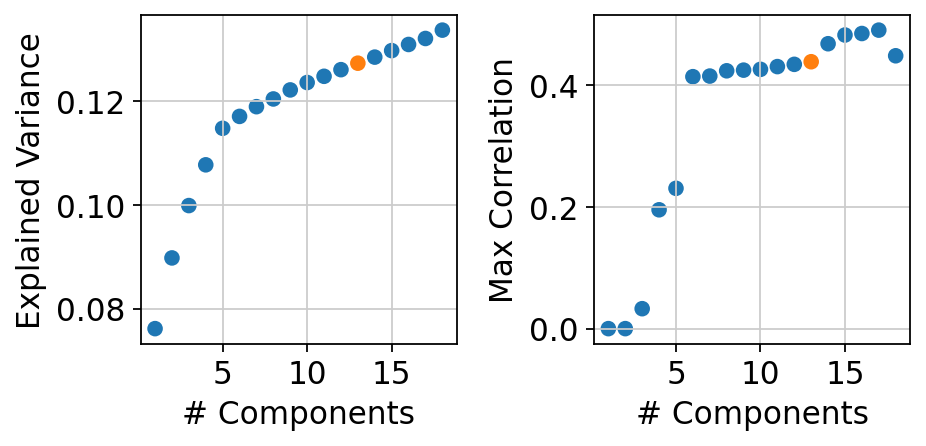

In [11]:
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
# plt.scatter(df_evar['n_comp'], df_evar['Evar'])
plt.scatter(df_evar['n_comp'], df_evar['Evar'], c=['tab:blue' if n_c != n_comp else 'tab:orange' for n_c in df_evar.n_comp])

plt.ylabel('Explained Variance')
plt.xlabel('# Components')

plt.subplot(1,2,2)
# plt.scatter(df_evar['n_comp'], df_evar['corr'])
plt.scatter(df_evar['n_comp'], df_evar['corr'], c=['tab:blue' if n_c != n_comp else 'tab:orange' for n_c in df_evar.n_comp])
plt.ylabel('Max Correlation')
plt.tight_layout()
plt.xlabel('# Components')

# plt.savefig(str(sc.settings.figdir) + '/stats_components_NMF.pdf', bbox_inches='tight')

## NMF

In [12]:
n_comp = 13

In [13]:
model = NMF(n_components=n_comp, init='random', random_state=seed)
H = model.fit_transform(arr_exp)
W = model.components_

df_evar = calc_EV(arr_exp.T, pd.DataFrame(W).T, pd.DataFrame(H).T)
    
for c in range(n_comp):
    adata.obs['NMF_{}'.format(c)] = H[:,[c]]
    adata.var['NMF_{}'.format(c)] = W[c,:]
adata.var[['NMF_{}'.format(c) for c in range(n_comp)]].to_csv('./data/NMF.W.PBMC.csv')

/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


Text(0, 0.5, 'Explained Variance')

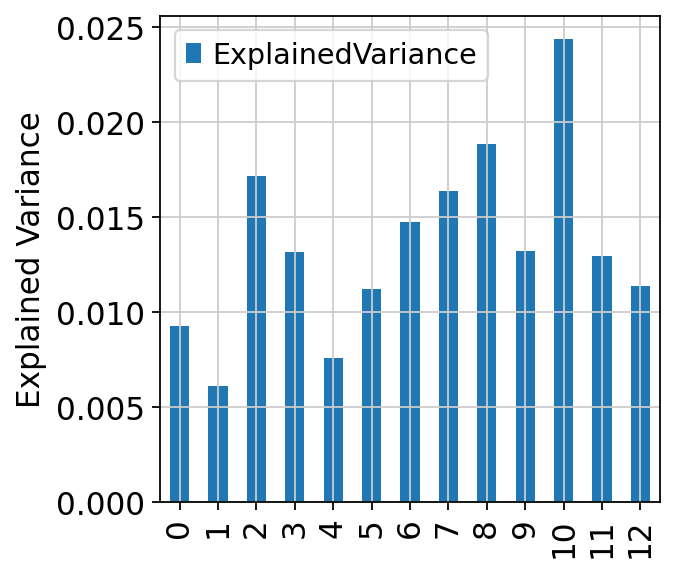

In [14]:
df_evar.iloc[:-1].plot.bar()
plt.ylabel('Explained Variance')

In [15]:
%%time
for c in range(n_comp):
    adata.raw.var['corr_NMF_{}'.format(c)] = np.corrcoef(adata.raw.X.T.todense(), adata.obs['NMF_{}'.format(c)])[-1,:-1]

/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/yyasumizu/anaconda3/envs/scanpy1.8.1/lib/python3.8/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


CPU times: user 3min 47s, sys: 30.6 s, total: 4min 17s
Wall time: 39.7 s


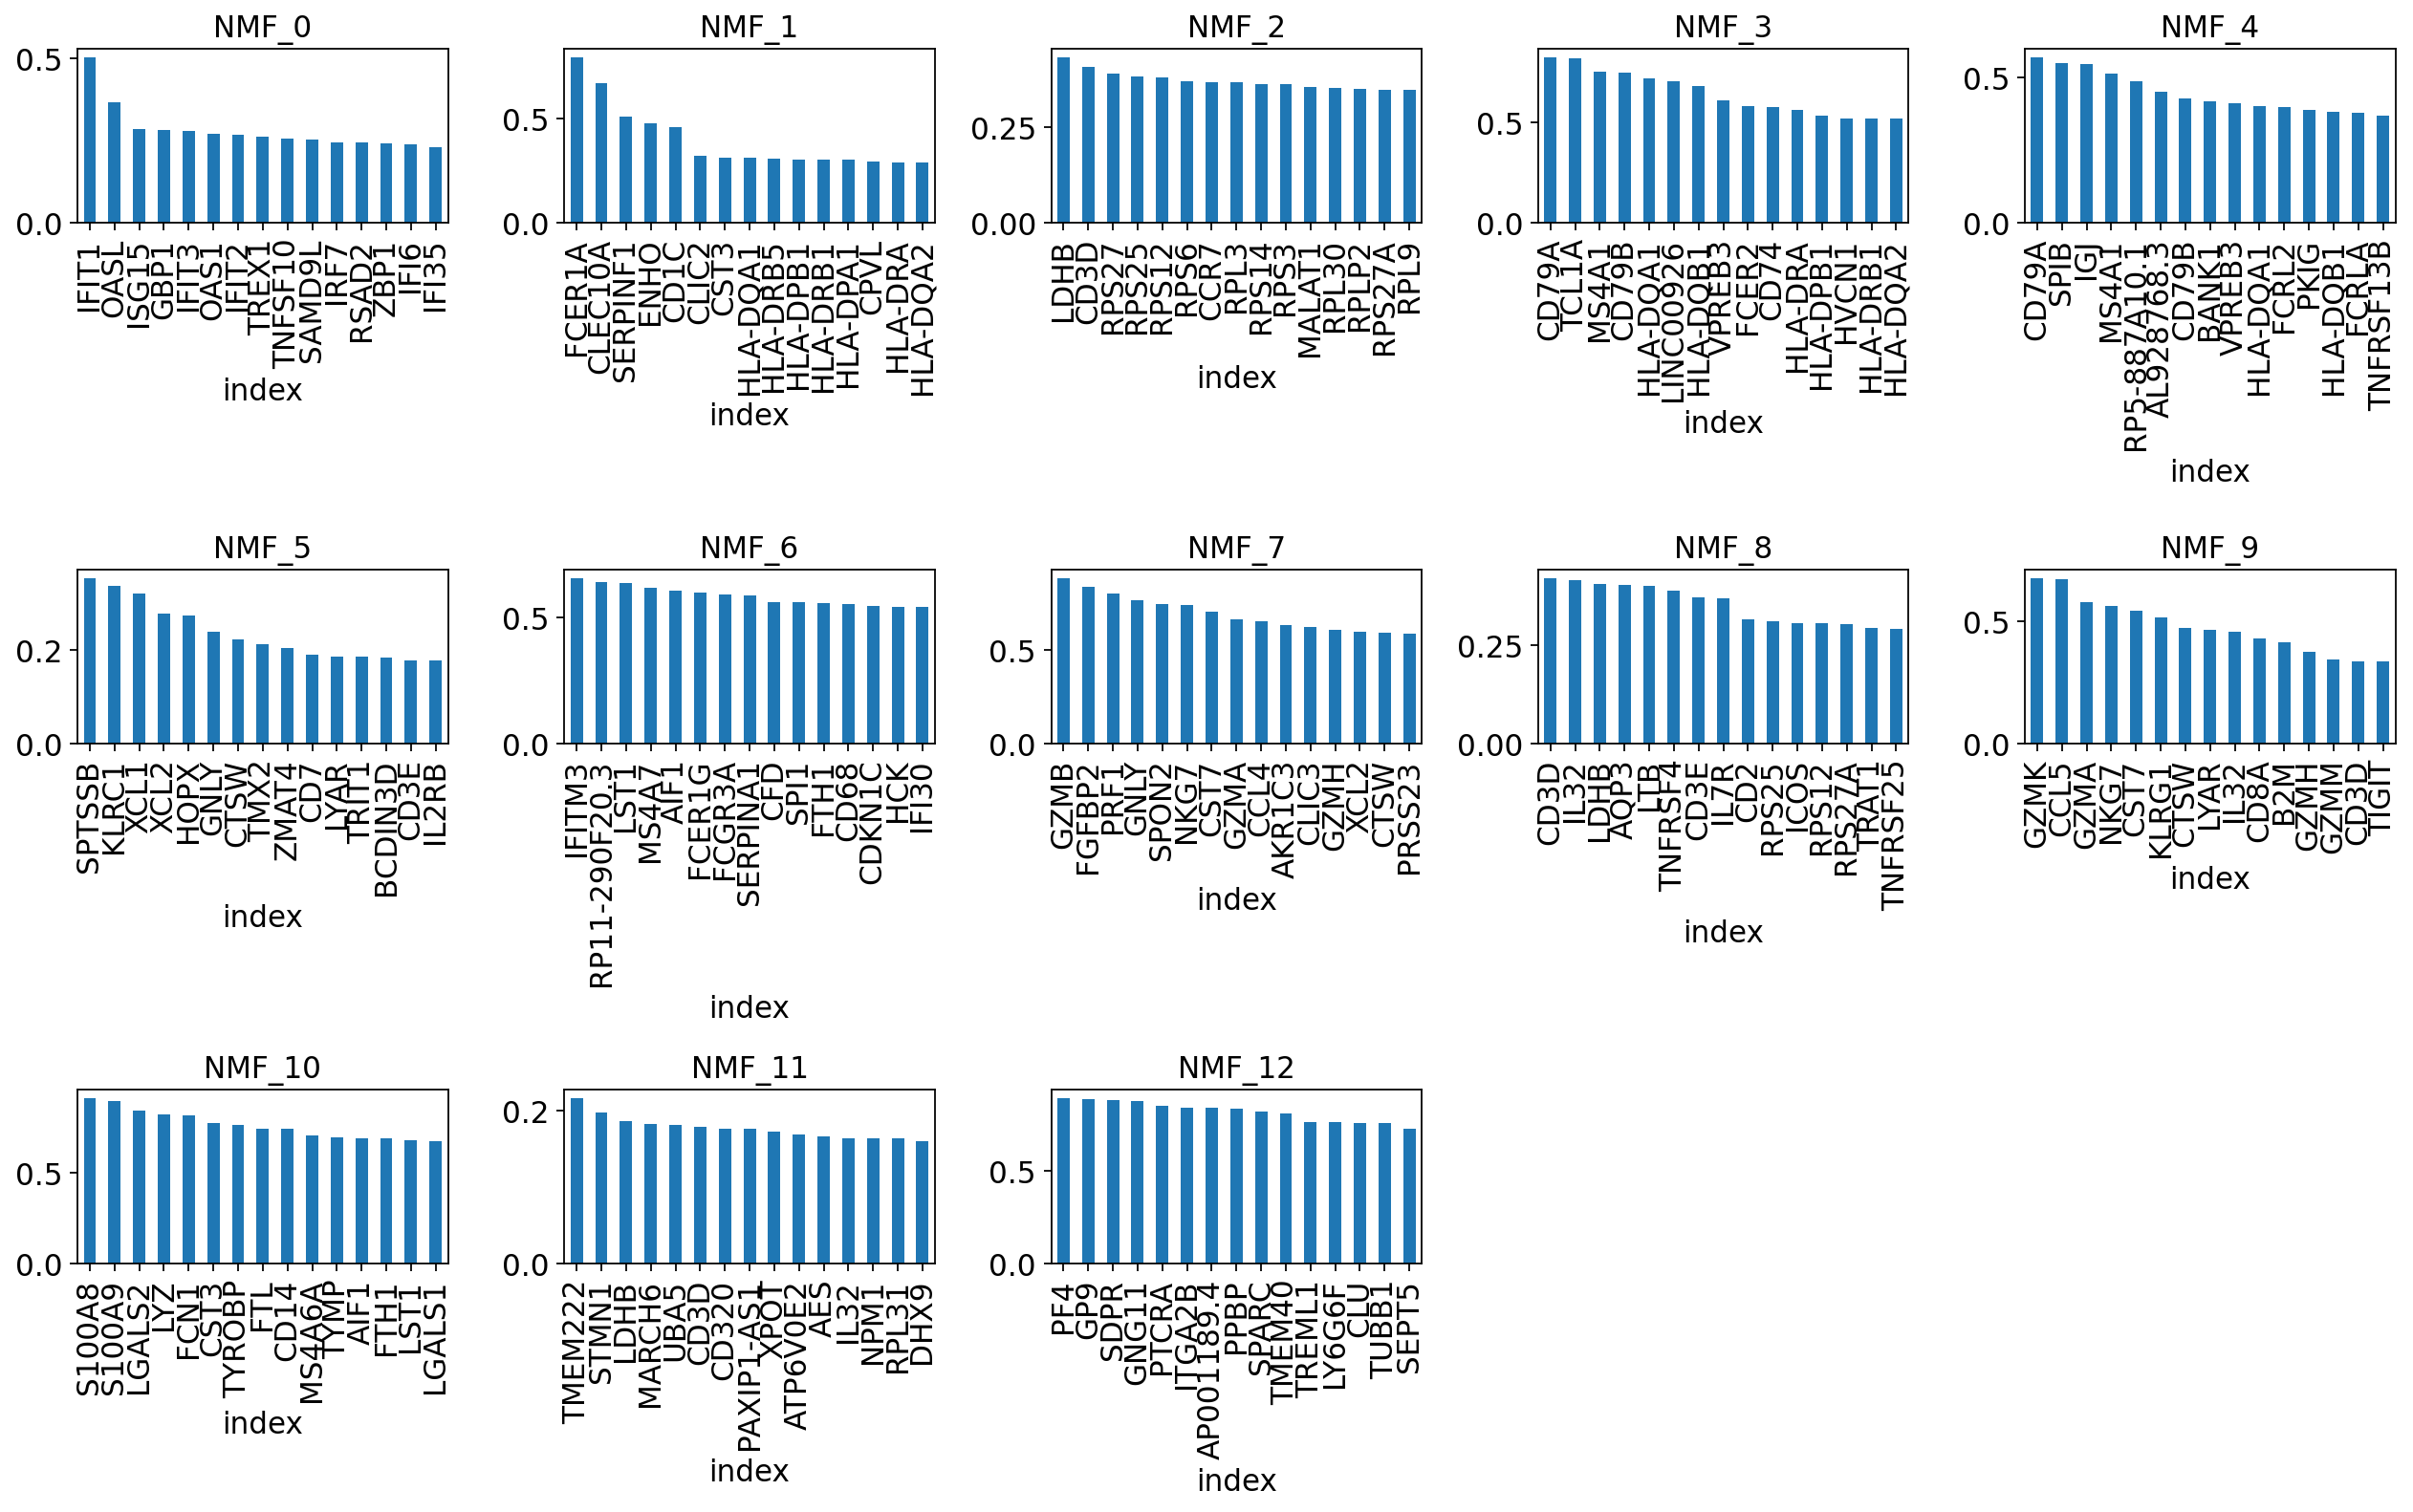

In [16]:
plt.figure(figsize=(16,12))
for i,c in enumerate(range(n_comp)):
    plt.subplot(4,5,i+1)
    adata.raw.var['corr_NMF_{}'.format(c)].sort_values(ascending=False).head(15).plot.bar()
    plt.grid(False)
    plt.title('NMF_{}'.format(c))
plt.tight_layout()
# plt.ylabel('R')
# plt.savefig(str(sc.settings.figdir) + '/bar_NMF_corrgenes.pdf', bbox_inches='tight')

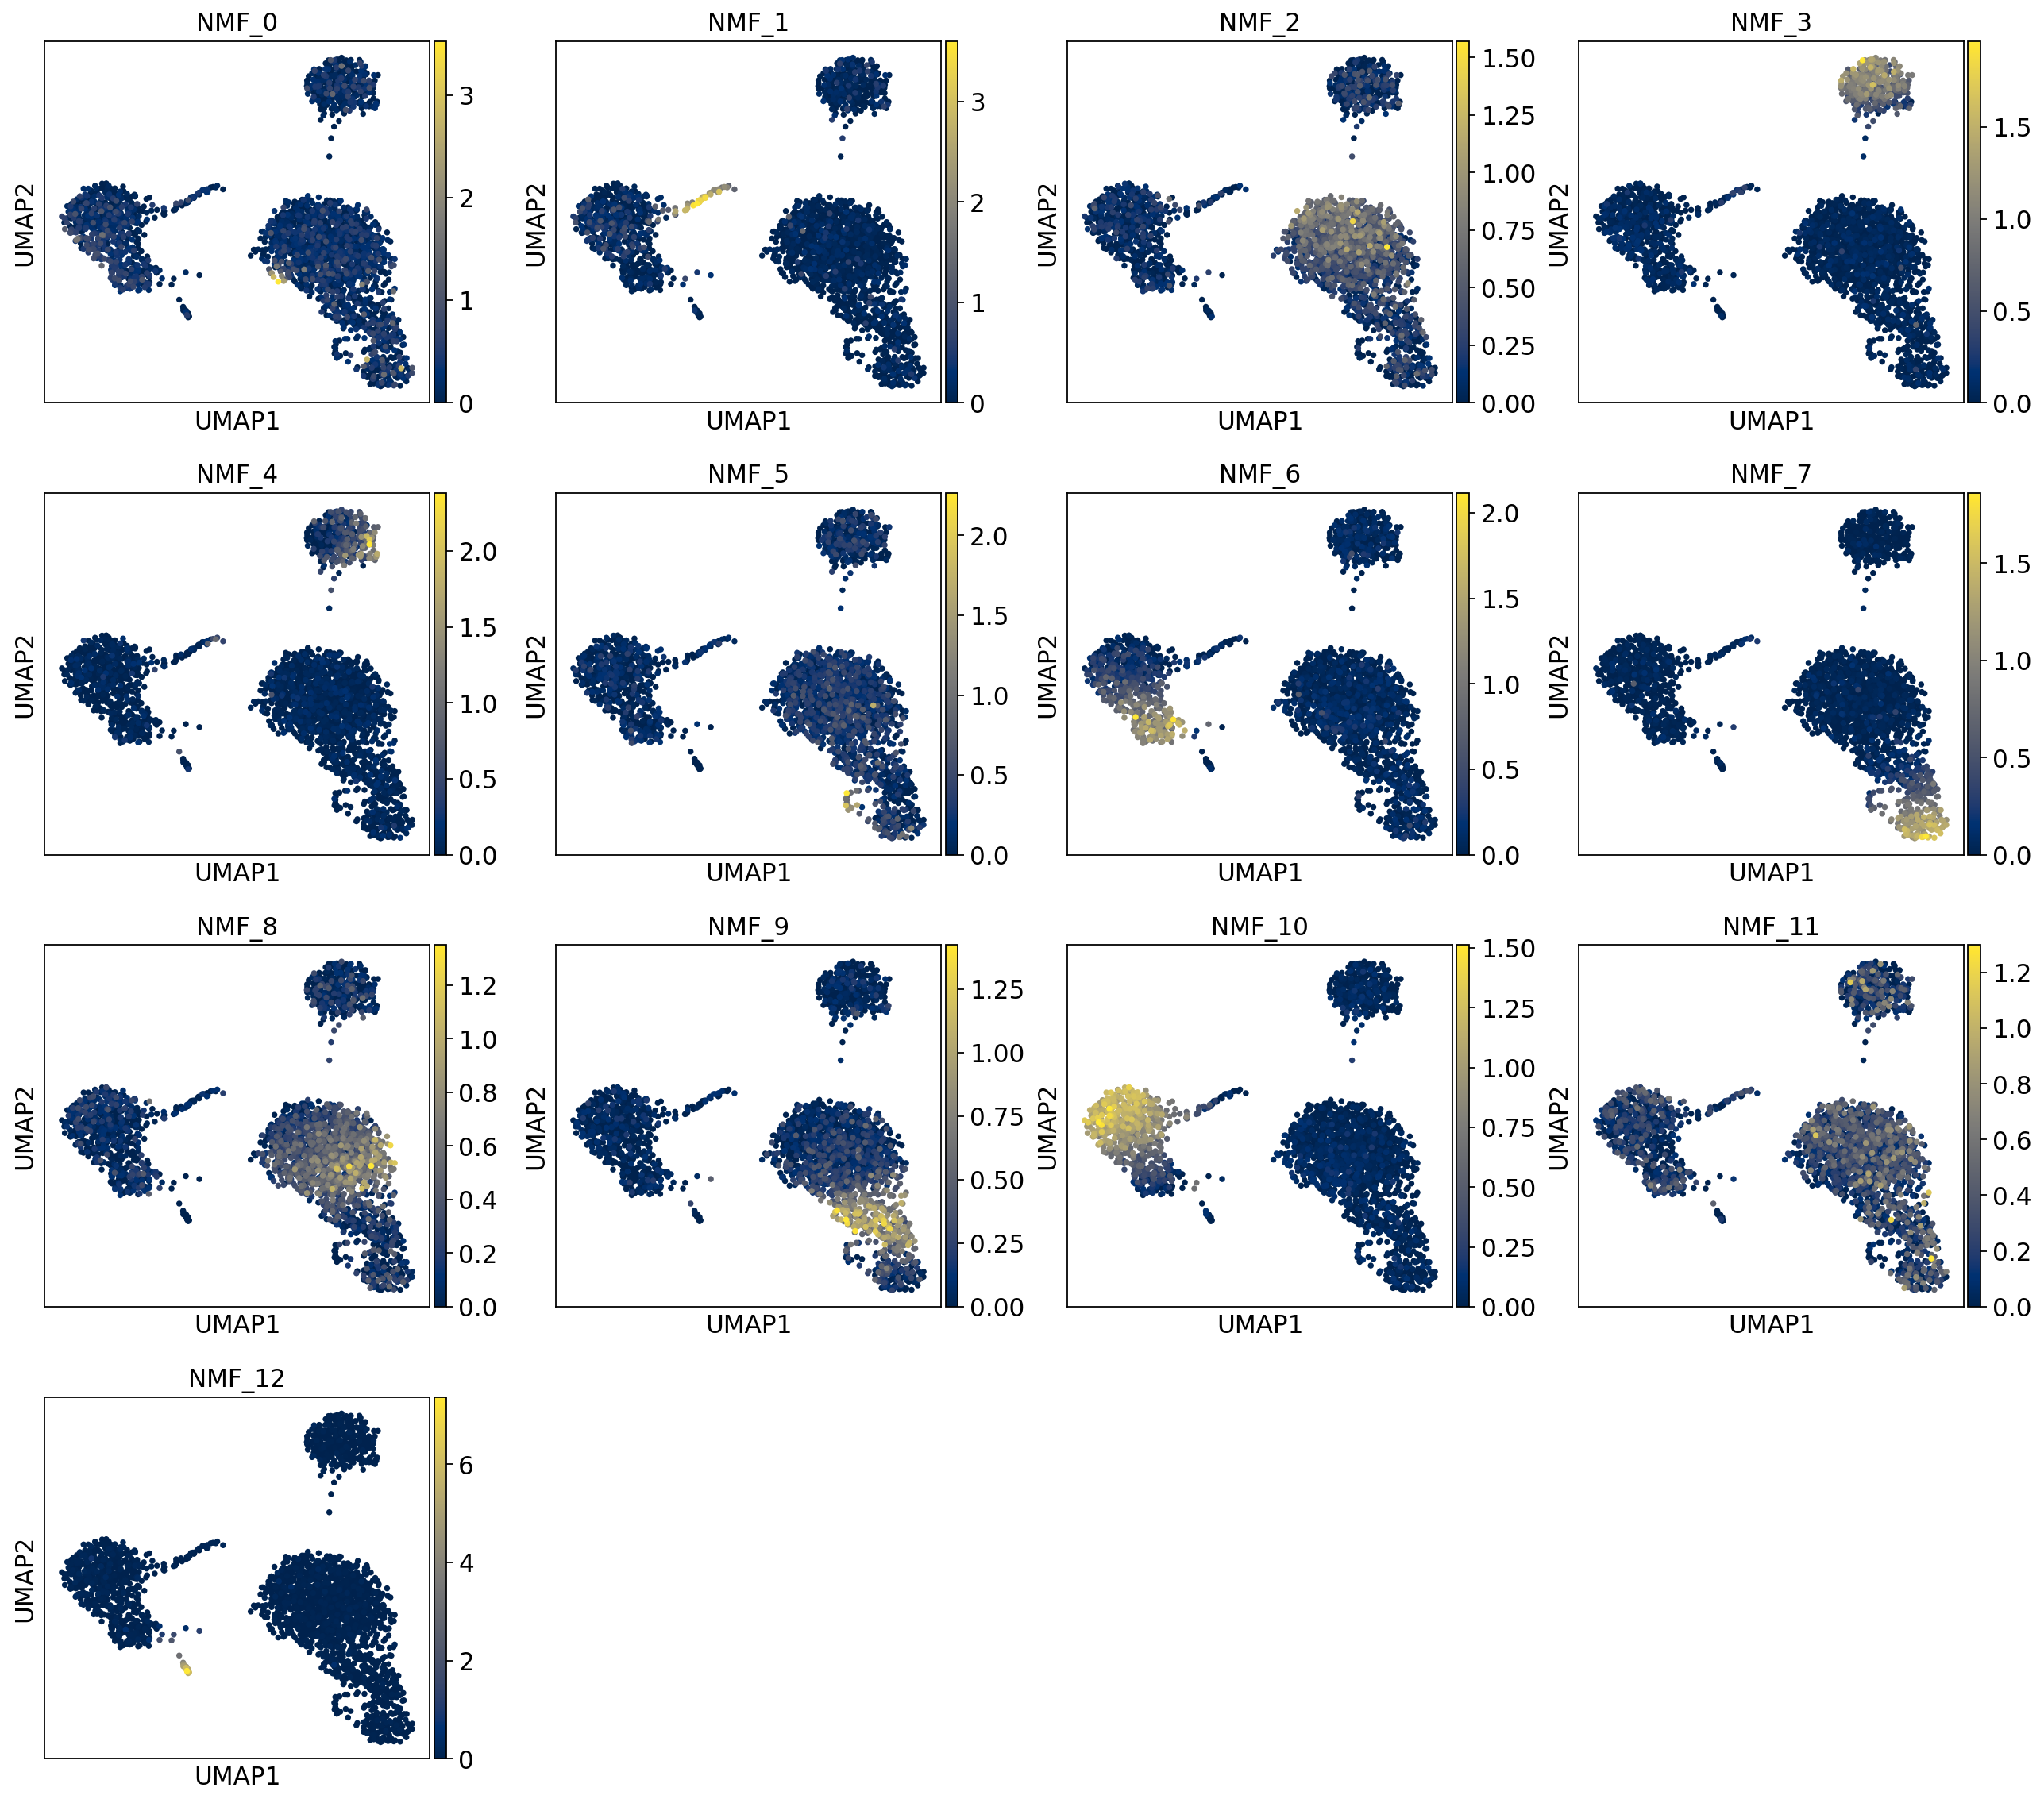

In [17]:
sc.pl.umap(adata, color=['NMF_{}'.format(c) for c in range(n_comp)], cmap='cividis')